Automated footprint ID in 2D spectral stack

In [37]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift, fftn

from scipy.ndimage import gaussian_filter, label

import skimage.morphology as morph
from skimage.measure import label

In [17]:
# mycarta's padding functions

def im_pad(im):
    out = np.zeros([3*im.shape[0],3*im.shape[1]])
    out[im.shape[0]:2*im.shape[0],im.shape[1]:2*im.shape[1]]=im
    return out

def im_unpad(im):
    out = im[im.shape[0]//3:2*im.shape[0]//3,im.shape[1]//3:2*im.shape[1]//3]
    return out

Load example dataset I'm familiar with (F3):

In [6]:
#The data file used for algo development
devfile = "../images_and_data/F3_original_subvolume_IL230-430_XL475-675_T200-1800.npy"

#Load it
data = np.load(devfile)

print("Data shape:" + str(data.shape))

Data shape:(201, 201, 401)


Have a gander at the data:

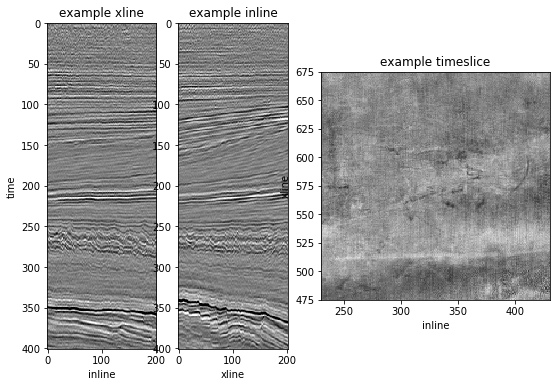

In [9]:
# find 99th percentile of amplitude for plot scaling
global_amp = np.percentile(data, 99.9)

# Plot the 3D data
atts = plt.figure(figsize=(9,6))

XL, IL, T = 100, 100, 100

# Look at XL
ax1 = atts.add_subplot(141)
ax1.imshow(data[:,XL,:].T, cmap="gray",vmin=-global_amp, vmax=global_amp, aspect='auto')
#ax1.xaxis.tick_top()
ax1.set_title('example xline')
ax1.set_xlabel('inline')
ax1.set_ylabel('time')

# Look at IL
ax1 = atts.add_subplot(142)
ax1.imshow(data[IL,:,:1000].T, cmap="gray",vmin=-global_amp, vmax=global_amp, aspect='auto')
#ax1.xaxis.tick_top()
ax1.set_title('example inline')
ax1.set_xlabel('xline')

# Look at T index 100
ax1 = atts.add_subplot(122)
ax1.imshow(data[:,:,T].T, extent=(230, 430, 475, 675), cmap="gray",vmin=-global_amp, vmax=global_amp, aspect='1') # I didn't plot the Transpose here
ax1.set_title('example timeslice')
ax1.set_xlabel('inline')
ax1.set_ylabel('xline');

Calculate a stack of 2D spectra and confirm shape

In [12]:
FS = np.zeros_like(data)

for i in range(data.shape[-1]):
    FS[:,:,i] = np.abs(fftshift(fft2(data[:,:,i])))

FS_filt = gaussian_filter(FS, [0,0,20])
    
FS.shape

(201, 201, 401)

Write a little plotting function:

In [100]:
def plot_spectra(spec, traces):
    
    XL, IL, T = traces
    
    atts = plt.figure(figsize=(10, 7))

    # Look at "XL" index 50
    ax1 = atts.add_subplot(141)
    ax1.imshow(spec[:,XL,:].T, cmap="gray")
    ax1.axhline(T, color='red')
    ax1.axvline(IL, color='red')

    # Look at "IL" index 50
    ax1 = atts.add_subplot(142)
    ax1.imshow(spec[IL,:,:].T, cmap="gray")
    ax1.axhline(T, color='red')
    ax1.axvline(XL, color='red')

    # Look at "T" index 150
    ax1 = atts.add_subplot(122)
    ax1.imshow(spec[:,:,T].T, cmap="gray")
    ax1.axhline(XL, color='red')
    ax1.axvline(IL, color='red');

Now look at the spectra stack:

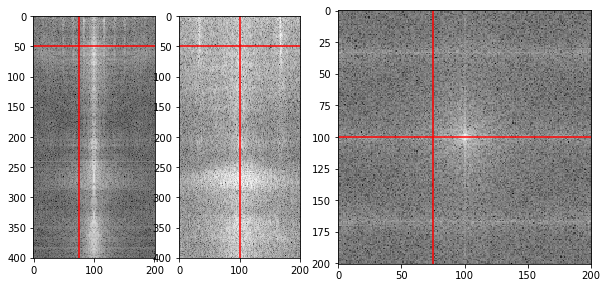

In [101]:
plot_spectra(np.log(FS), (100,75,50))

And the filtered version that enhances the footprint:

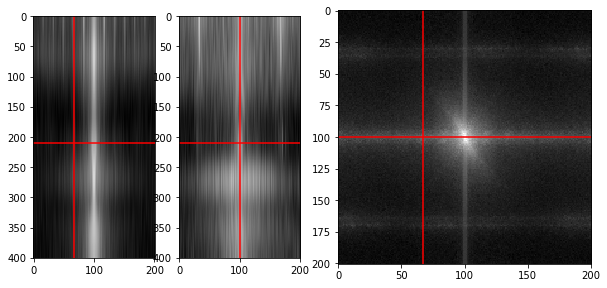

In [93]:
plot_spectra(np.log(FS_filt), (100,67,210))

### Create an element to protect the geological info contained in the spectral core

In [96]:
def define_core(spectra, threshold, dilation_radius, plot=False):
    """
    Creates a binary array equivalent to the 2D spectral stack that
    identifies the location basic geological information. Can be used
    to protect this information during spectral filtering.
    
    spectra : input stack of 2D spectra
    threshold : amplitude threshold used to identify 'core' data (ranges
                between 1-100, but likely <5)
    dilation_radius: radius of sphere used for morphologic dilation
    plot : enter a list of (XL, IL, T) to plot results
    
    Returns binary array of same shape as input
    
    """
    
    # Scale spectra to 0-100
    fs = spectra * 100/np.max(spectra)

    # Apply a binary threshold
    binary = np.zeros(fs.shape, dtype=np.uint8)
    binary[fs > threshold] = 1
    
    # Identify and retain largest element, discard the rest:
    label_objects = label(binary) # label discrete bodies
    sizes = np.bincount(label_objects.ravel()) # calculate sizes
    sizes[0] = 0 # first body is background... set volume to zero
    mask_sizes = sizes == np.max(sizes) # find largest remaining body - should be core
    fs_core = mask_sizes[label_objects]*1. # Leave only core
    
    # Dilate the binary array to eliminate noise and smooth the element boundaries
    binary_dilated_bool = morph.binary_dilation(fs_core, selem=morph.ball(dilation_radius))
    binary_dilated = np.zeros(spectra.shape, dtype=np.uint8) # turn bool into binary, pt.1
    binary_dilated[binary_dilated_bool] = 1 # turn bool into binary, pt.2
    
    if plot:
        plot_spectra(binary_dilated, plot)
        plot_spectra(np.log(FS), plot)
        
    return binary_dilated

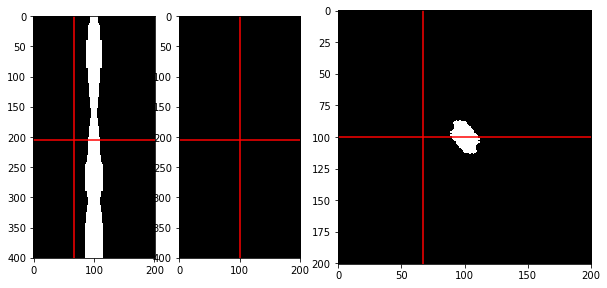

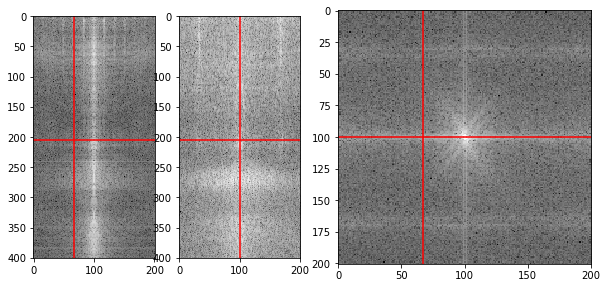

In [97]:
FS_core = define_core(FS_filt, 4., 2, (100,67,205))

### Isolating the footprint from the 2D spectra stack

Can we isolate the footprint?

In [457]:
def iter_erosion(array, iterations, selem=None):
    # Applies erosion a number of times
    out = np.copy(array)
    for i in range(iterations):
        out = morph.erosion(out, selem=selem)
    
    return out

In [174]:
def auto_2D_spec_stack_filter(spectra, local_radius, local_max_threshold, spectral_core=False, spectral_smoothing=False, plot=False):
    """
    Automatic creation of filter to remove aquisition footprint. Recommend
    specifying a spectral core.
    
    spectra : input stack of 2D spectra
    local_radius : radius of smoothing used to find local peaks on spectra slice
    local_max_threshold : relative amplitude threshold value for local highs (ranges
                        between 1-100, but likely <5)
    spectral_core : binary array indicating where core geology information occurs.
                    Expecting array generated by define_core.
    spectral_smoothing : sigma for gaussian filter applied to local maxima, should be
                         scalar or sequence of scalars
    
    
    threshold : amplitude threshold used to identify 'core' data
    dilation_radius: radius of sphere used for morphologic dilation
    plot : enter a list of (XL, IL, T) to plot results
    
    Returns binary array of same shape as input
    
    """
    
    # Scale spectra to 0-100
    fs = spectra * 100/np.max(spectra)
    
    # Apply gaussion smoothing along time axis of 2D spectral stack:
    fs_filt = gaussian_filter(fs, [0,0,20])
    
    # Find local highs on each slice by taking difference between
    # fs_filt and a fs_filt smoothed across the slice
    fs_filt_local_max = (fs_filt -
                         gaussian_filter(fs_filt, (local_radius,local_radius,0)))
    
    # Apply a threshold to identify local maxima of interest
    fs_filt_local_max[fs_filt_local_max <= local_max_threshold] = 0
    
    # Make binary by assigning values > 0 to 1
    fs_filt_local_max[fs_filt_local_max > 0] = 1
    
    if not isinstance(spectral_core, bool):
        # Remove spectral core, if provided:
        fs_filt_local_max[spectral_core == 1] = 0
        
    # Smooth the spectra of the filter to eliminate ringing artifacts generated by edges:
    if spectral_smoothing:
        fs_footprint_filter = gaussian_filter(fs_filt_local_max, spectral_smoothing)
    else:
        fs_footprint_filter = fs_filt_local_max

    if plot:
        plot_spectra(np.log(fs_footprint_filter+1), plot)
        plot_spectra(np.log(spectra), plot)
        
    return fs_footprint_filter

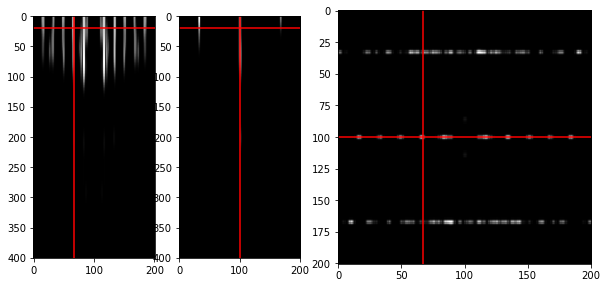

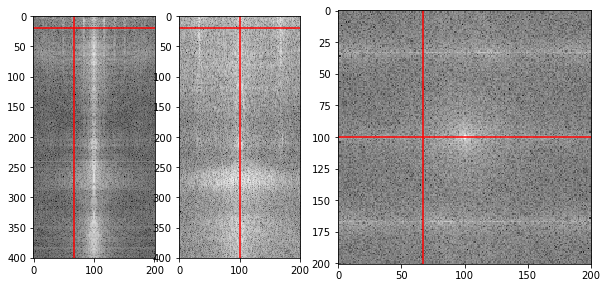

In [175]:
FS_filter = auto_2D_spec_stack_filter(FS, 2, 0.3, FS_core, spectral_smoothing=(1,1,10), plot=(100,67,20))

Apply the filter:

In [155]:
def apply_spectral_filter(data, spectral_filter, filter_strength, plot=False):
    """
    Apply a 2D spectral stack filter to a dataset
    
    data : input data
    spectral_filter : a 2D spectral stack filter, such as one designed by
                      auto_2D_spec_stack_filter
    filter_strength : scalar defining the strength of filter. Typically,
                      0.5-1.5 .
    
    returns filtered data
    
    """    
    
    # Initialize output array
    data_filtered = np.copy(data)
    
    for i in range(data.shape[2]):
        orig_fs = fft2(data[:,:,i])

        filtered_fs = np.multiply(1 - (filter_strength * ifftshift(spectral_filter[:,:,i])),
                                  orig_fs)

        data_filtered[:,:,i] = np.real(ifft2(filtered_fs))
        
        
    if plot:
        input_fs = np.zeros_like(data_filtered)
        output_fs = np.zeros_like(data_filtered)

        for i in range(data.shape[-1]):
            input_fs[:,:,i] = np.abs(fftshift(fft2(data[:,:,i])))
            output_fs[:,:,i] = np.abs(fftshift(fft2(data_filtered[:,:,i])))
        
        plot_spectra(np.log(output_fs), plot)
        plot_spectra(np.log(input_fs), plot)
        
    return data_filtered

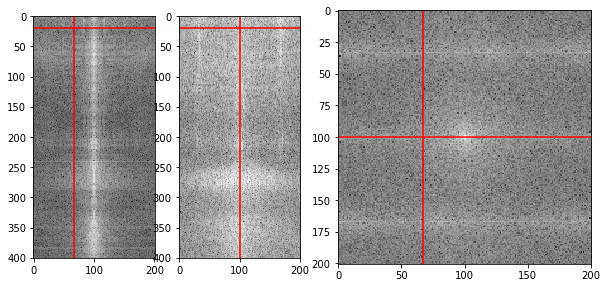

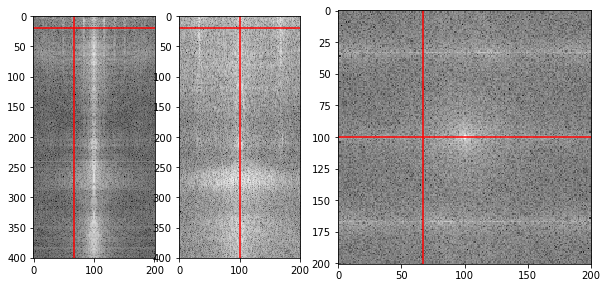

In [163]:
data_filtered = apply_spectral_filter(data, spectral_filter=FS_filter,
                                      filter_strength=1.5, plot=(100,67,20))

filtered_diff = data - data_filtered

View the results in section and timeslice:

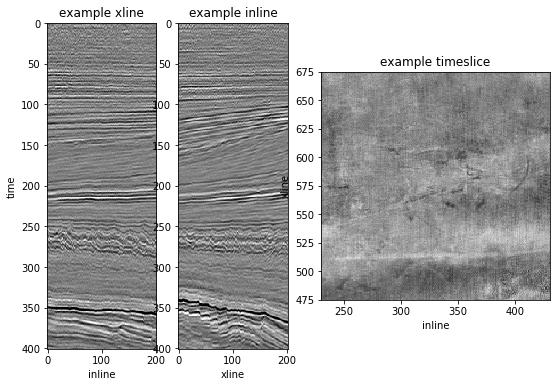

In [161]:
# find 99th percentile of amplitude for plot scaling
global_amp = np.percentile(data, 99.9)

# Plot the 3D data
atts = plt.figure(figsize=(9,6))

XL, IL, T = 100, 100, 100

# Look at XL
ax1 = atts.add_subplot(141)
ax1.imshow(data_filtered[:,XL,:].T, cmap="gray",vmin=-global_amp, vmax=global_amp, aspect='auto')
#ax1.xaxis.tick_top()
ax1.set_title('example xline')
ax1.set_xlabel('inline')
ax1.set_ylabel('time')

# Look at IL
ax1 = atts.add_subplot(142)
ax1.imshow(data_filtered[IL,:,:1000].T, cmap="gray",vmin=-global_amp, vmax=global_amp, aspect='auto')
#ax1.xaxis.tick_top()
ax1.set_title('example inline')
ax1.set_xlabel('xline')

# Look at T index 100
ax1 = atts.add_subplot(122)
ax1.imshow(data_filtered[:,:,T].T, extent=(230, 430, 475, 675), cmap="gray",vmin=-global_amp, vmax=global_amp, aspect='1') # I didn't plot the Transpose here
ax1.set_title('example timeslice')
ax1.set_xlabel('inline')
ax1.set_ylabel('xline');

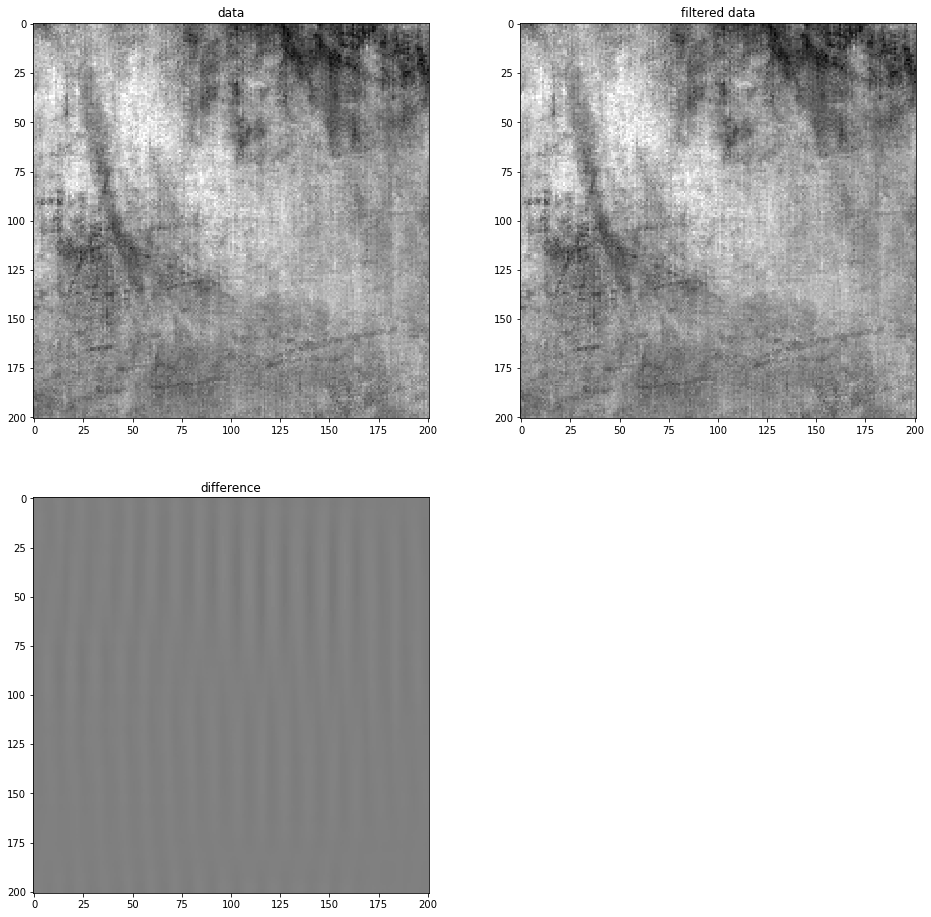

In [173]:
time_slice = 80

atts = plt.figure(figsize=(16,16))
ax1 = atts.add_subplot(221)
ax1.imshow(data[:,:,time_slice].T, cmap='gray', vmin=-global_amp, vmax=global_amp,)
ax1.set_title('data')
ax2 = atts.add_subplot(222)
ax2.imshow(data_filtered[:,:,time_slice].T, cmap='gray', vmin=-global_amp, vmax=global_amp,)
ax2.set_title('filtered data')
ax3 = atts.add_subplot(223)
ax3.imshow(filtered_diff[:,:,time_slice].T, cmap='gray', vmin=-global_amp, vmax=global_amp,)
ax3.set_title('difference');